# test2p4_par.ipynb

A notebook to launch multiple parallel tests of the task in test2p4.

# PART 4
Using a global error measure in the SPF__M learning rule.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool

/home/z/projects/draculab


In [2]:
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

In [3]:
def create_t2p4_net(params):
    """ Create a network to run a variation of test2 part 4. 
    
        Args:
            params : parameter dictionary with these entries: 
            N = size of each population
            t_pres = duration of each pattern presentation
            M__P_type = type of M__P connections. See M__P_mats below
            M_type = oscillator model. Either "am_pulse","am_pm", "am", or "am2D"
            SPF__M_syn_type = synapse_types.rga_ge or node_pert
            om_var = omega frequency heterogeneity (float)
            track_SPF__M_w = Boolean. Whether to track SPF__M weight for 1 M(E|I) unit
        Returns:
            The draculab network created with these parameters.
    """
    N = params['N']
    t_pres = params['t_pres']
    M__P_type = params['M__P_type']
    M_type = params['M_type']
    SPF__M_syn_type = params['SPF__M_syn_type']
    om_var = params['om_var']
    track_SPF__M_w = params['track_SPF__M_w']
    
    #--------------------------------------------------------------

    M__P_mats = {'identity' : 1.*np.eye(N),
                 'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
                 'overcomplete2' : np.random.random((N, 3*N))}
    if N > 1:
        M__P_mats['overcomplete'] = np.concatenate((M__P_mats['identity'], M__P_mats['haar']), axis=1)
    norms = np.linalg.norm(M__P_mats['overcomplete2'], axis=0)
    M__P_mats['overcomplete2'] = M__P_mats['overcomplete2']/norms
    W = M__P_mats[M__P_type]
    M_N = W.shape[1]

    des_pat = np.zeros(N) # desired pattern in SP
    des_pats = np.random.random((2000, N)) # many desired patterns for SP
    des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
    par_heter = 0.1 # range of heterogeneity as a fraction of the original value
    randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

    net_params = {'min_delay' : 0.002,
                  'min_buff_size' : 10 }
    GE_params = {'type' : unit_types.sigmoidal,
                 'thresh' : 0.4,
                 'slope' : 4.,
                 'tau' : 0.02,
                 'tau_fast': 0.05,
                 'tau_mid' : 1.,
                 'delay' : 0.3,
                 'extra_requirements' : ['lpf_fast', 'lpf_mid'],
                 'init_val' : 0.2 }
    SF_params = {'type' : unit_types.sigmoidal,
                 'thresh' : 0. * randz(),
                 'slope' : 1. * randz(),
                 'init_val' : 0.2 * randz(),
                 'tau' : 0.05 }#* randz() }
    SP_params = {'type' : unit_types.source,
                 'init_val' : 0.5,
                 'function' : lambda x: None }
    SPF1_params = {'type' : unit_types.out_norm_sig,
                  'thresh' : 0.3 * randz(), # 0.5 originally
                  'slope' : 6. * randz(),  # 4. originally
                  'delay' : 0.3,
                  'init_val' : 0.3 * randz(),
                  'tau_fast': 0.01, # 0.005
                  'tau_mid': 0.2,  # 0.05
                  'tau_slow' : 30., # 5
                  'tau' : 0.05, #* randz(),
                  'des_out_w_abs_sum' : 2. }
    SPF2_params = SPF1_params
    P_params = {'type' : unit_types.linear,
                'init_val' : 0.,
                'tau' : 0.05 }#* randz() }

    if M_type == "am_pm":
        init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
        M_syn_type = unit_types.am_pm_oscillator
    elif M_type == "am2D":
        init_base = np.array([0.5, 0.5])
        M_syn_type = unit_types.am_oscillator2D
    elif M_type == "am_pulse":
        init_base = np.array([0.5, 0.5])
        M_syn_type = unit_types.am_pulse
    elif M_type == "am":
        init_base = np.array([0.5, 0.5, 0.5])
        M_syn_type = unit_types.am_oscillator
    M_params = {'type' : M_syn_type,
                'integ_meth' : 'odeint',
                'tau_u' : 0.1,
                'tau_c' : .1, # originally 0.2
                'tau_s' : 0.04,
                'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
                'multidim' : True,
                'n_ports' : 3,
                'inp_deriv_ports' : 2 if SPF__M_syn_type==synapse_types.node_pert else [[0,1,2]]*M_N,
                'omega' : .5*np.pi,
                'custom_inp_del' : 300,
                'tau_fast': 0.01,
                'tau_mid' : 0.1,
                'tau_slow' : 1.,
                'delay' : 0.24,
                'A' : .5,
                'mu' : 0.,
                'sigma' : 0.0 }

    def create_freqs_steps(n, w, r):
        """ Returns a 2-tuple with the lists required for heterogeneous frequencies.

            Args:
                n : number of units
                w : base angular (rad/s)
                r : amplitude of noise
            Returns
                2-tuple : (freqs, steps)
                freqs : a list with n angular frequencies.
                steps : a list with the corresponding delays. 
        """
        ws = w + r*(np.random.random(n) - 0.5)
        #ws = ws / M_params['tau_t'] # angular frequencies
        mp_del = np.arctan(P_params['tau']*ws)/ws
        psf_del = np.arctan(SF_params['tau']*ws)/ws
        sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
        spfm_del1 = np.arctan(M_params['tau_c']*ws)/ws
        spfm_del2 = np.arctan(M_params['tau_u']*ws)/ws
        d1 = mp_del + psf_del + sfspf_del + 4.*0.02
        del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
        return (list(ws), del_steps)

    # creating units
    net = network(net_params)
    GE = net.create(1, GE_params)
    SF = net.create(N, SF_params)
    SP = net.create(N, SP_params)
    SPF1 = net.create(N, SPF1_params)
    SPF2 = net.create(N, SPF2_params)
    P = net.create(N, P_params)

    omegasE, del_stepsE = create_freqs_steps(M_N, M_params['omega'], om_var)
    M_params['omega'] = omegasE
    M_params['custom_inp_del'] = del_stepsE
    M_params['delay'] = net_params['min_delay'] * (del_stepsE[0]+2)
    ME = net.create(M_N, M_params)

    omegasI, del_stepsI = create_freqs_steps(M_N, M_params['omega'], om_var)
    M_params['omega'] = omegasI
    M_params['custom_inp_del'] = del_stepsI
    M_params['delay'] = net_params['min_delay'] * (del_stepsE[0]+2)
    MI = net.create(M_N, M_params)

    pops = {'GE' : GE, 'SF':SF, 'SP':SP, 'SPF1':SPF1, 'SPF2':SPF2, 'P':P, 'ME':ME, 'MI':MI}
    
    # set the pattern in SP
    def make_fun(idx):
        #return lambda t: des_pat[idx]
        return lambda t: des_pats[int(round(t/t_pres)),idx]
    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))

    # Create the connections. See note on "detecting layer distances" in cortex wiki
    GE__ME_conn  = {'rule' : 'all_to_all',
                    'delay' : 0.02 }
    GE__ME_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
    GE__MI_conn  = GE__ME_conn
    GE__MI_syn = GE__ME_syn
    SF__SPF1_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SF__SPF2_conn = SF__SPF1_conn
    SF__SPF1_syn = {'type' : synapse_types.static,
                   'init_w' : -1. }
    SF__SPF2_syn = {'type' : synapse_types.static,
                   'init_w' : 1. }
    SP__SPF1_conn = {'rule' : "one_to_one",
                    'delay' : 0.02 }
    SP__SPF2_conn = SP__SPF1_conn
    SP__SPF1_syn = {'type' : synapse_types.static,
                   'init_w' : 1. }
    SP__SPF2_syn = {'type' : synapse_types.static,
                   'init_w' : -1. }
    SPF1__GE_conn = {'rule' : 'all_to_all',
                     'delay' : 0.02 }
    SPF1__GE_syn = {'type' : synapse_types.static,
                    'init_w' : 1./N }
    SPF2__GE_conn = SPF1__GE_conn
    SPF2__GE_syn = SPF1__GE_syn
    SPF1__ME_conn = {'rule': 'all_to_all',
                    'delay': 0.02 }
    SPF2__ME_conn = SPF1__ME_conn
    SPF1__MI_conn = SPF1__ME_conn
    SPF2__MI_conn = SPF1__ME_conn
    SPF1__ME_syn = {'type' : SPF__M_syn_type,
                    'lrate': 4.,
                    #'post_delay': del_steps,
                    'inp_ports': 0,
                    'max_w' : 2.,
                    'min_w' : 0.,
                    'sig1' : .2,
                    'sig2' : .2,
                    'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
    SPF2__ME_syn = SPF1__ME_syn
    SPF1__MI_syn = SPF1__ME_syn
    SPF2__MI_syn = SPF1__ME_syn

    # Specify the connection matrix from ME/MI to P
    #W = 2.*np.eye(N)
    #W = haar_matrix(3) # only for N = 2**dim

    # connect ME/MI to P
    ME__P_conn = {'rule': 'all_to_all',
                  'delay': 0.02 }
    ME__P_syn = {'type': synapse_types.static_l1_normal,
                 'w_sum' : 2.,
                 'tau_norml' : 5.,
                 'init_w' : W.flatten() }
    MI__P_conn = ME__P_conn
    MI__P_syn = {'type': synapse_types.static_l1_normal,
                 'w_sum' : 2.,
                 'tau_norml' : 5.,
                 'init_w' : -W.flatten() }
    # From P to SF
    P__SF_conn = {'rule' : 'one_to_one',
                  'delay' : 0.02 }
    P__SF_syn = {'type' : synapse_types.static,
                 'init_w' : 3. }
    # lateral connections in M
    ME__ME_conn = {'rule': 'all_to_all',
                   'allow_autapses' : False,
                   'delay' : 0.02 }
    ME__ME_syn = {'type' : synapse_types.static,
                  'lrate' : 0.1,
                  'inp_ports': 1,
                  'init_w' : -0.01/N }
    ME__MI_conn = {'rule': 'one_to_one',
                   'delay' : 0.02 }
    ME__MI_syn = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : -0.5 } # -0.5 }
    MI__ME_conn = ME__MI_conn
    MI__ME_syn = ME__MI_syn
    MI__MI_conn = ME__ME_conn
    MI__MI_syn = ME__ME_syn

    net.connect(GE, ME, GE__ME_conn, GE__ME_syn)
    net.connect(GE, MI, GE__MI_conn, GE__MI_syn)
    net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
    net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
    net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
    net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
    net.connect(SPF1, GE, SPF1__GE_conn, SPF1__GE_syn)
    net.connect(SPF2, GE, SPF2__GE_conn, SPF2__GE_syn)
    net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
    net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
    net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
    net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
    net.connect(ME, P, ME__P_conn, ME__P_syn)
    net.connect(MI, P, MI__P_conn, MI__P_syn)
    net.connect(P, SF, P__SF_conn, P__SF_syn)
    net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
    net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
    net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
    net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

    # tracking state variables of the am_pm_oscillator
    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }
    def create_state_track(uid, var_id):
        return lambda t: net.units[uid].buffer[var_id,-1]
    if M_type == "am":
        n_track = 3
    elif M_type == "am2D":
        n_track = 2
    elif M_type == "am_pm":
        n_track = 4
    M_track = net.create(n_track, track_params)
    for var in range(n_track):
        net.units[M_track[var]].set_function(create_state_track(ME[0],var))
    pops['M_track'] = M_track

    if track_SPF__M_w:
        # tracking SPF__ME weights
        SPF__M_track = net.create(2*N, track_params)
        SPF__M_syns = [syn for syn in net.syns[ME[0]] if syn.port == SPF1__ME_syn['inp_ports']]
        def SPF__M_fun(idx):
            """ Creates a function to track a weight from SPF to ME. """
            return lambda t: SPF__M_syns[idx].w
        for idx in range(len(SPF1+SPF2)):
            net.units[SPF__M_track[idx]].set_function(SPF__M_fun(idx))
        pops['SPF__M_track'] = SPF__M_track
    
    return net, pops

In [4]:
def run_config(cfg):
    """ Returns simualtion data for a given parameter configuration.
    
    Args:
        cfg: a parameter dictionary with these entries:
          'N' : plant dimensionality
          't_pres' : time for each presentation
          'M__P_type' : connection matrix type for M__P. See create_t2p4_net
          'M_type' : unit type for M. Either "am_pulse","am_pm", "am", or "am2D"
          'SPF__M_syn_type' : synapse type for SPF__M. Either rga_ge or node_pert
          'om_var' : heterogeneity in oscillation frequency for M units
          'track_SPF__M_w' : Whether to track whte SPF__M weights through time
          
    Returns: A dictionary with the entries:
        'times' : times for data points
        'data' : numpy array with activities for all units
        'pops' : unit IDs for all populations
    """
    numpy.random.seed() # will try to get a seed from /dev/urandomrandomrandomrandom
    net, pops = create_t2p4_net(cfg)
    sim_time = 300.
    times, data, _ = net.flat_run(sim_time)
    data = np.array(data)
    results = {'times' : times,
               'data' : np.array(data),
               'pops' : pops}
    return results

def eval_config(cfg):
    """ Returns a mean error for a given parameter configuration.
    
    Args:
        cfg: a parameter dictionary with these entries:
          'N' : plant dimensionality
          't_pres' : time for each presentation
          'M__P_type' : connection matrix type for M__P. See create_t2p4_net
          'M_type' : unit type for M. Either "am_pulse","am_pm", "am", or "am2D"
          'SPF__M_syn_type' : synapse type for SPF__M. Either rga_ge or node_pert
          'om_var' : heterogeneity in oscillation frequency for M units
          'track_SPF__M_w' : Whether to track whte SPF__M weights through time
          
    Returns:
        The mean value of the norm of SP-SF for the second half of the simulation
    """
    np.random.seed() # will try to get a seed from /dev/urandomrandomrandomrandom
    net, pops = create_t2p4_net(cfg)
    sim_time = 300.
    times, data, _ = net.flat_run(sim_time)
    data = np.array(data)
    init_idx = int(np.round(len(times)/2.))
    SP_data = np.array(data[pops['SP']])
    SF_data = np.array(data[pops['SF']])
    if cfg['N'] > 1:
        SP_data_unit = (SP_data/np.linalg.norm(SP_data, axis=0))
        SF_data_unit = (SF_data/np.linalg.norm(SF_data, axis=0))
        SP_SF = SP_data_unit - SF_data_unit
    else:
        SP_SF = SP_data - SF_data
    SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
    print("run of eval_config done for N=%d, M__P_type=%s"%(cfg['N'], cfg['M__P_type']))

    return np.mean(SP_SF_norm[init_idx:])

In [5]:
####################
#  Configurations  #
####################

# Creating simulations for a range of values of N and M__P_type
base_config = {
    'N' : None,
    't_pres' : 50., 
    'M__P_type' : None, 
    'M_type' : "am2D", 
    'SPF__M_syn_type' : synapse_types.node_pert,
    'om_var' : 1.,
    'track_SPF__M_w' : False
    }

Ns = [1, 2, 4, 8]
M__P_types = ['identity', 'haar', 'overcomplete', 'overcomplete2']

configs = []
for N in Ns:
    for M__P_type in M__P_types:
        cfg = base_config.copy()
        cfg['N'] = N
        cfg['M__P_type'] = M__P_type
        if N > 1 or M__P_type == 'identity':
            configs.append(cfg)
            
configs = 2*configs # run every configuration many times

In [6]:
# Parallel runs of 'eval_config'
n_procs = 12
print('Starting %d processes' % (n_procs))
start_time = time.time()
with Pool(n_procs) as p:
    all_errors = list(p.map(eval_config, configs))
    p.close()
    p.join()
print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 

Starting 12 processes
run of eval_config done for N=1, M__P_type=identity
run of eval_config done for N=2, M__P_type=haar
run of eval_config done for N=2, M__P_type=identity
run of eval_config done for N=1, M__P_type=identity
run of eval_config done for N=2, M__P_type=overcomplete
run of eval_config done for N=4, M__P_type=haar
run of eval_config done for N=2, M__P_type=identity
run of eval_config done for N=4, M__P_type=identity
run of eval_config done for N=2, M__P_type=haar
run of eval_config done for N=2, M__P_type=overcomplete2
run of eval_config done for N=2, M__P_type=overcomplete
run of eval_config done for N=4, M__P_type=overcomplete
run of eval_config done for N=4, M__P_type=identity
run of eval_config done for N=4, M__P_type=haar
run of eval_config done for N=2, M__P_type=overcomplete2
run of eval_config done for N=8, M__P_type=haar
run of eval_config done for N=8, M__P_type=identity
run of eval_config done for N=4, M__P_type=overcomplete2
run of eval_config done for N=4, M_

In [7]:
# Create results matrices from 'all_errors'
# rows will be number of units, columns the M__P connection type
rga = [[[] for _ in M__P_types] for _ in Ns]
rga_ge = [[[] for _ in M__P_types] for _ in Ns]
rga_21 = [[[] for _ in M__P_types] for _ in Ns]
static = [[[] for _ in M__P_types] for _ in Ns]
n_p = [[[] for _ in M__P_types] for _ in Ns]

syn2mat = {synapse_types.rga : rga,
           synapse_types.rga_21 : rga_21,
           synapse_types.rga_ge : rga_ge,
           synapse_types.static : static,
           synapse_types.node_pert : n_p }
ct2idx = {'identity' : 0,
          'haar': 1,
          'overcomplete' : 2,
          'overcomplete2': 3 }
N2idx = [None, 0, 1, None, 2, None, None, None, 3]

for error, cfg in zip(all_errors, configs):
    syn2mat[cfg['SPF__M_syn_type']][
            N2idx[cfg['N']]][ct2idx[cfg['M__P_type']]].append(error)
    
rga_res = np.zeros((len(Ns), len(M__P_types)))
rga_21_res = np.zeros((len(Ns), len(M__P_types)))
rga_ge_res = np.zeros((len(Ns), len(M__P_types)))
static_res = np.zeros((len(Ns), len(M__P_types)))
n_p_res = np.zeros((len(Ns), len(M__P_types)))

mat_pairs = [(rga, rga_res), (rga_21, rga_21_res), (rga_ge, rga_ge_res),
             (static, static_res), (n_p, n_p_res)]
for m1, m2 in mat_pairs:
    for row_idx, row in enumerate(m1):
        for col_idx, col in enumerate(row):
            if col: # if element not empty
                m2[row_idx][col_idx] = np.mean(col)

In [8]:
n_p_res

array([[0.09434555, 0.        , 0.        , 0.        ],
       [0.45457859, 0.35750859, 0.45606926, 0.43220932],
       [0.58888816, 0.43286011, 0.51968145, 0.49757733],
       [0.54825308, 0.47221024, 0.4793209 , 0.43420439]])

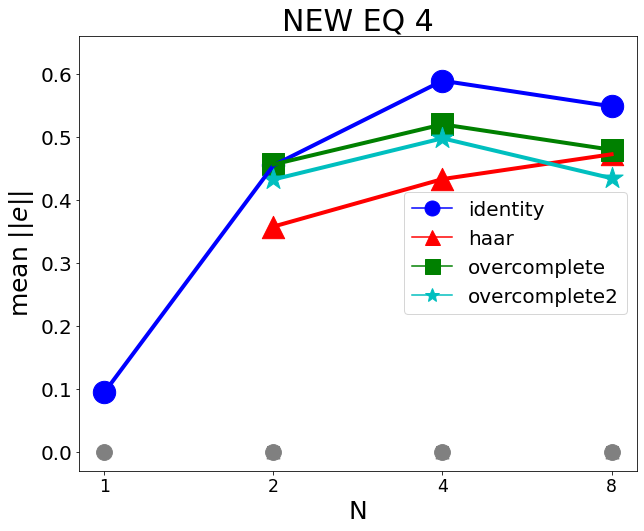

In [9]:
mat = 'node_pert'
mat_dict = {'rga' : rga_res,
            'rga_21' : rga_21_res,
            'rga_ge' : rga_ge_res,
            'static' : static_res,
            'node_pert' : n_p_res }
title_dict = {'rga' : 'EQUATION 2',
            'rga_21' : 'EQUATION 3',
            'rga_ge' : 'EQUATION 4',
            'static' : 'CONTROL',
            'node_pert' : 'NEW EQ 4'}
fig = plt.figure(figsize=(10,8))
res = mat_dict[mat]
labels = ['' for _ in range(4)]
plt.xticks([1,2,3,4], ['1', '2', '4', '8'], fontsize='xx-large')
plt.yticks(fontsize=20)
plt.xlabel('N', fontsize=25)
plt.ylabel('mean $||e||$', fontsize=25)
plt.title(title_dict[mat], fontsize=30)
plt.ylim([-0.03, 0.66])

colors=['b', 'r', 'g', 'c']
for key in ct2idx:
    labels[ct2idx[key]] = key # so order is preserved
plt.plot(list(range(1,5)), res[:,0], linewidth=4, color=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.plot(list(range(2,5)), res[1:,idx+1], linewidth=4, color=colors[idx+1])
#plt.legend(labels, fontsize='20')

import matplotlib.lines as mlines

markers = ['o', '^', 's', '*',]
ms = 500 # marker size
plt.scatter(list(range(1,5)), res[:,0], s=ms, c=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), res[1:,idx+1], s=ms, marker=markers[idx+1], c=colors[idx+1])

dot = mlines.Line2D([],[], marker='o', markersize=15, color=colors[0], label=labels[0])
tri = mlines.Line2D([],[], marker='^', markersize=15, color=colors[1], label=labels[1])
squ = mlines.Line2D([],[], marker='s', markersize=15, color=colors[2], label=labels[2])
sta = mlines.Line2D([],[], marker='*', markersize=15, color=colors[3], label=labels[3])
plt.legend(handles=[dot,tri,squ,sta], fontsize='20')

# plotting control data    
plt.scatter(list(range(1,5)), static_res[:,0], s=int(ms/2), c='gray')
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), static_res[1:,idx+1], s=int(ms/3), marker=markers[idx+1], c='gray')
    
plt.show()

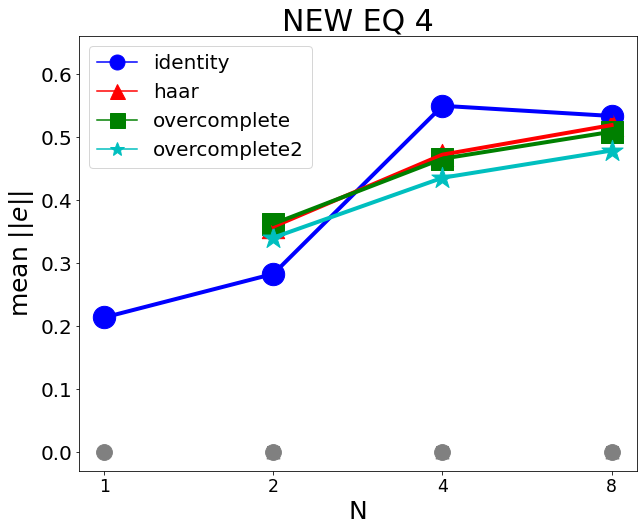

In [11]:
mat = 'node_pert'
mat_dict = {'rga' : rga_res,
            'rga_21' : rga_21_res,
            'rga_ge' : rga_ge_res,
            'static' : static_res,
            'node_pert' : n_p_res }
title_dict = {'rga' : 'EQUATION 2',
            'rga_21' : 'EQUATION 3',
            'rga_ge' : 'EQUATION 4',
            'static' : 'CONTROL',
            'node_pert' : 'NEW EQ 4'}
fig = plt.figure(figsize=(10,8))
res = mat_dict[mat]
labels = ['' for _ in range(4)]
plt.xticks([1,2,3,4], ['1', '2', '4', '8'], fontsize='xx-large')
plt.yticks(fontsize=20)
plt.xlabel('N', fontsize=25)
plt.ylabel('mean $||e||$', fontsize=25)
plt.title(title_dict[mat], fontsize=30)
plt.ylim([-0.03, 0.66])

colors=['b', 'r', 'g', 'c']
for key in ct2idx:
    labels[ct2idx[key]] = key # so order is preserved
plt.plot(list(range(1,5)), res[:,0], linewidth=4, color=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.plot(list(range(2,5)), res[1:,idx+1], linewidth=4, color=colors[idx+1])
#plt.legend(labels, fontsize='20')

import matplotlib.lines as mlines

markers = ['o', '^', 's', '*',]
ms = 500 # marker size
plt.scatter(list(range(1,5)), res[:,0], s=ms, c=colors[0])
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), res[1:,idx+1], s=ms, marker=markers[idx+1], c=colors[idx+1])

dot = mlines.Line2D([],[], marker='o', markersize=15, color=colors[0], label=labels[0])
tri = mlines.Line2D([],[], marker='^', markersize=15, color=colors[1], label=labels[1])
squ = mlines.Line2D([],[], marker='s', markersize=15, color=colors[2], label=labels[2])
sta = mlines.Line2D([],[], marker='*', markersize=15, color=colors[3], label=labels[3])
plt.legend(handles=[dot,tri,squ,sta], fontsize='20')

# plotting control data    
plt.scatter(list(range(1,5)), static_res[:,0], s=int(ms/2), c='gray')
for idx, label in enumerate(labels[1:]):
    plt.scatter(list(range(2,5)), static_res[1:,idx+1], s=int(ms/3), marker=markers[idx+1], c='gray')
    
plt.show()

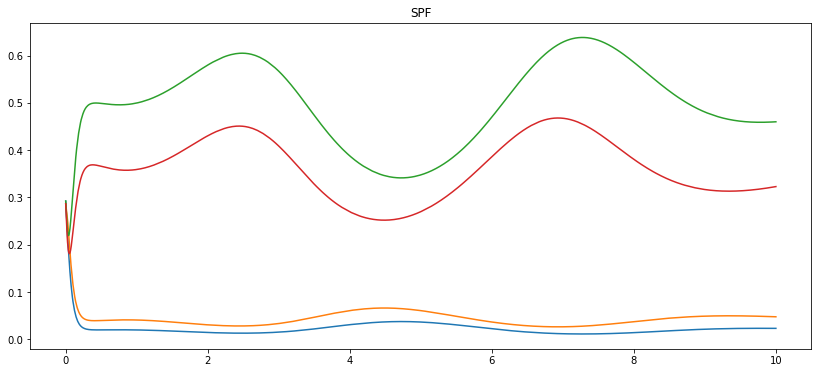

[0.02322785 0.04770646 0.46006606 0.32302369]


NameError: name 'N' is not defined

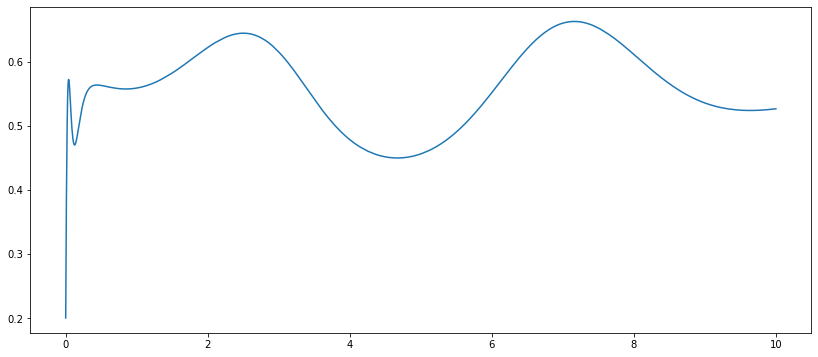

In [11]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# GE
GE_fig = plt.figure(figsize=fs)
GE_data = np.array(data[GE])
plt.plot(times, GE_data[0])
plt.plot(times, (1./N)*np.sum(SPF_data, axis=0), linewidth=2)
plt.title('GE')
plt.show()
print(GE_data[-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])



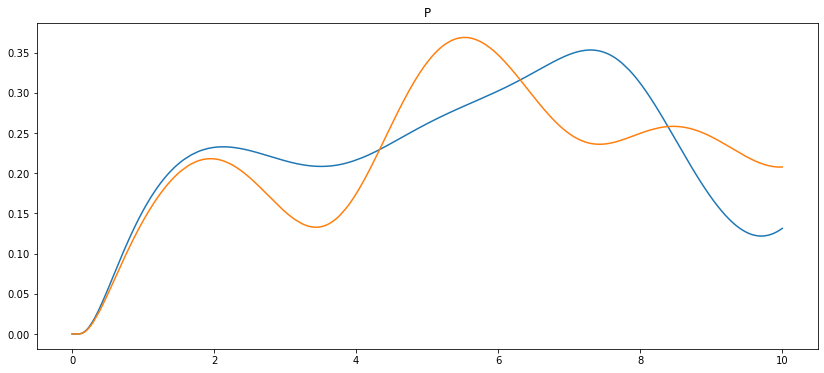

[0.13137995 0.20779258]


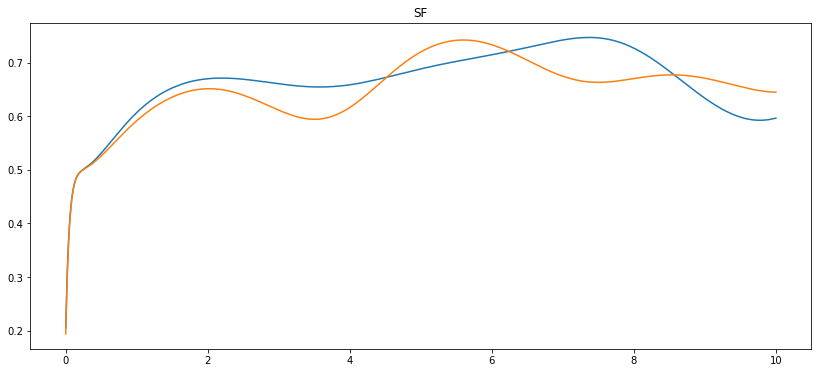

[0.59667278 0.64496925]
[0.56837441 0.92256801]


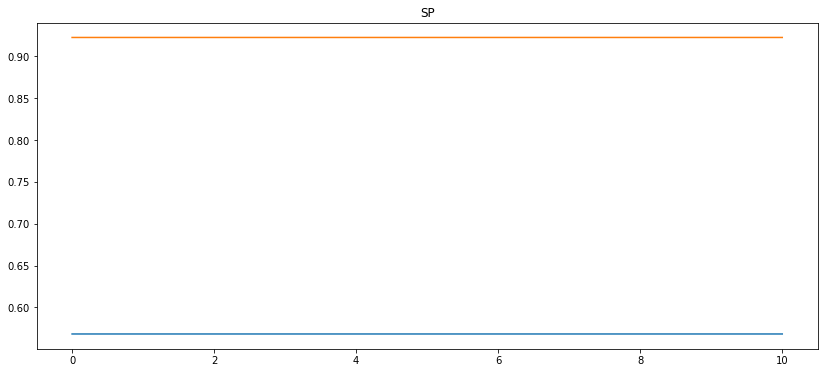

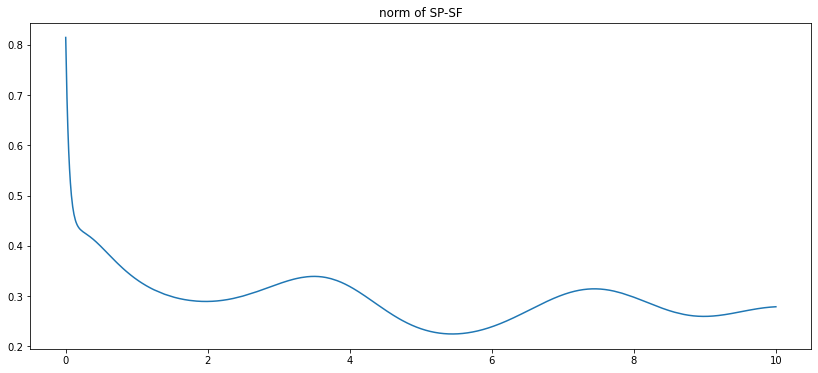

In [13]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


NameError: name 'M_type' is not defined

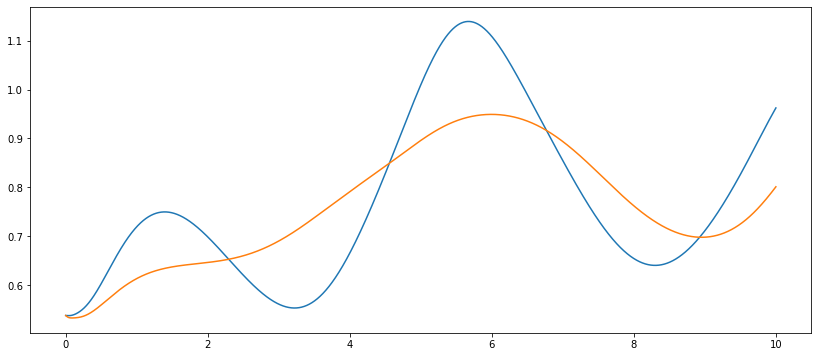

In [18]:
# state var trackers
M_track_fig = plt.figure(figsize=fs)
track_data = np.array(data[M_track])
plt.plot(times, data[M_track[0]])
plt.plot(times, data[M_track[1]])
if M_type == "am":
    plt.plot(times, data[M_track[2]])
elif M_type == "am_pm":
    plt.plot(times, data[M_track[3]])
if M_type == "am2D":
    plt.legend(['u','c'])
else:
    plt.legend(['u','c','I'])
#plt.plot(times, track_data.trose())
#plt.plot(times, data[ME[0],:],'r')
plt.title(' state vars sample')

# weight tracking
W_fig1 = plt.figure(figsize=fs)
w_track_data1 = np.array(data[SPF__M_track[0:N]])
w_track_data2 = np.array(data[SPF__M_track[N:]])
plt.plot(times, w_track_data1.transpose())
SPF__M_legends1 = ['SPF1['+str(i)+']--M' for i in range(N)]
plt.plot(times, w_track_data2.transpose())
SPF__M_legends2 = ['SPF2['+str(i)+']--M' for i in range(N)]
plt.legend(SPF__M_legends1+SPF__M_legends2)
plt.title('SPF--M weights')

# joint plot
joint_fig, axs = plt.subplots(2, 2, figsize=(2.2*fs[0], 2.2*fs[1]))
axs[0][0].plot(times, SPF_data.transpose(), linewidth=2)
axs[0][0].set_title('SPF')
axs[0][1].plot(times, GE_data[0])
axs[0][1].set_title('GE')
axs[1][0].plot(times, ME_data.transpose())
axs[1][0].plot(times, MI_data.transpose())
axs[1][0].set_title('ME, MI')
axs[1][1].plot(times, SP_data.transpose())
axs[1][1].plot(times, SF_data.transpose())
axs[1][1].set_title('SP, SF')

plt.show()

In [11]:
m_id = 0
net = runna.nets[n_conf]
for idx, syn in enumerate(net.syns[ME[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

NameError: name 'runna' is not defined

In [26]:
m_id = 0
for idx, syn in enumerate(net.syns[MI[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

0) GE (0) --> MI[0], w=1.000000, port=2
1) SPF1 (5) --> MI[0], w=0.084141, port=0
2) SPF1 (6) --> MI[0], w=0.069115, port=0
3) SPF2 (7) --> MI[0], w=0.083853, port=0
4) SPF2 (8) --> MI[0], w=0.058570, port=0
5) MI (16) --> MI[0], w=-0.005000, port=1
6) MI (17) --> MI[0], w=-0.005000, port=1
7) MI (18) --> MI[0], w=-0.005000, port=1
8) ME (11) --> MI[0], w=-0.500000, port=1


In [5]:
# DEPRECATED CODE
class t2p4_runner():
    """ A class to launch parallel runs of test2 part 4. 
    
        Args:
            configs: a list whose elements are parameter dictionaries for"""
    def __init__(self, configs):
        self.name = 'initial_test'
        self.n_procs = len(configs) # how many processes
        self.n_nets = len(configs) # how many nets
        self.nets = [create_t2p4_net(conf) for conf in configs]
        self.pops = [n[1] for n in self.nets]
        self.nets = [n[0] for n in self.nets]
        
    def run_net(self, net, sim_time):
        #net = arg[0]
        #sim_time = arg[1]
        #print('Running network %d' % (net_num))
        print('Running a network')
        data = net.run(sim_time)
        return net, data
    
    def run_all(self, sim_time):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        pool = ProcessingPool(nodes=self.n_procs) 
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        #self.all_data = pool.map(self.run_net, zip(range(self.n_nets),[sim_time]*self.n_nets))
        #self.nets_data = pool.map(self.run_net, zip(self.nets,[sim_time]*self.n_nets))
        self.nets_data = pool.map(self.run_net, self.nets, [sim_time]*self.n_nets)
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        #return self.data
#         if save:
#             for net in self.nets:
#                 net.history.append('net object being saved in container t2p4_runner object ' + self.name)
#             F = open(self.name+'.pkl', 'wb')
#             dill.dump(self, F)
#             F.close()
#         if log:
#             self.log()
                
#     def log(self, file_name=log_file):
#         for net in self.nets:
#             net.log(file_name, params=(net.net_number == 0))
            

In [6]:
# DEPRECATED CODE
# running with the runner
sim_time = 3.
runna = t2p4_runner(configs)
#all_data = runna.run_all(sim_time)
runna.run_all(sim_time)
all_data = runna.all_data

# if running with runner, prepare data
n_conf = 2
times, data, _ = all_data[n_conf]
for name in runna.pops[n_conf]:
    exec(name + '=' + str(runna.pops[n_conf][name]))
data = np.array(data)
N = configs[n_conf]['N']
M_type = configs[n_conf]['M_type']

Running a network
Running a network
Starting 4 processes, 4 networks
Running a network
Running a network
****** Processing finished after 17.201724767684937 seconds ******
